In [17]:
import json
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from var_simulator import VarSimulator
import utils

import warnings
warnings.filterwarnings('ignore')

## GraphQL queries

In [2]:
accounts_query_string = """
query GetAccounts($last: ID) {
  accounts(first: 1000, where: {id_gt: $last, hasBorrowed: true}) {
    id
    totalBorrowValueInEth
    totalCollateralValueInEth
    tokens {
      id
      symbol
      cTokenBalance
      totalUnderlyingSupplied
      totalUnderlyingRedeemed
      totalUnderlyingBorrowed
      totalUnderlyingRepaid
      storedBorrowBalance
    }
  }
}
"""

markets_query_string = """{
  markets(first: 15, orderBy: totalSupply, orderDirection: desc) {
    name
    reserves
    supplyRate
    symbol
    id
    totalBorrows
    totalSupply
    underlyingPriceUSD
  }
}"""

## fetch data

### init CompoundSubgraphQuery

In [3]:
csg = utils.CompoundSubgraphQuery()

### fetch and save borrow positions

In [6]:
csg.query_borrow_positions(accounts_query_string)

saved file to: data/borrow_positions_29.pkl: : 30it [01:37,  3.26s/it]


### get top 1000 positions

In [4]:
df_top_1000_borrow_accounts = csg.read_top_borrow_accounts(top_n=1000)
df_top_borrow_positions = csg.parse_borrow_positions(df_top_1000_borrow_accounts)

### get top compound markets

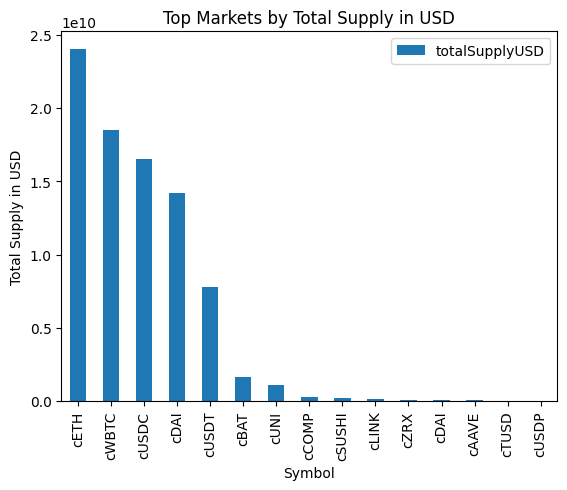

In [5]:
df_top_markets = csg.query_top_compound_markets(markets_query_string)
top_markets_symbols = list(df_top_markets['symbol'].head(15).apply(lambda x: x.strip('c')))
top_markets_symbols.append('BTC')
df_top_markets.plot.bar(x='symbol', y='totalSupplyUSD')
plt.title('Top Markets by Total Supply in USD')
plt.xlabel('Symbol')
plt.ylabel('Total Supply in USD')
plt.show()

### fetch markets data

In [90]:
CG_API_KEY = ''
BINANCE_API_KEY = ''

In [168]:
prices = fetch_binance_markets_data(top_markets_symbols, days=31, interval='1h', api_key=BINANCE_API_KEY)
with open('data/prices.pkl', 'wb') as f_out:
    pickle.dump(prices, f_out)

fetching prices data for BTC: 100%|█████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


In [6]:
with open('data/prices.pkl', 'rb') as f:
    prices = pickle.load(f)

## simulation - calculate volatility and simulations using GARCH

In [10]:
df_prices = utils.prices_dict_to_df(prices, intervals_count=720, fillna=True)
df_prices = df_prices.rename(columns={"BTC": "WBTC"})
df_prices.index = pd.to_datetime(df_prices.index, format='%Y-%m-%d %H:%M')

### init VarSimulator

In [11]:
vsim = VarSimulator(df_prices)

### fit GRACH models and measure their fit using log-likelihood and AIC

In [7]:
p_grid = range(1, 5)
q_grid = range(1, 5)
best_aic = 0
best_loglik = 0
best_p = None
best_q = None
n_tests = 720

In [14]:
with tqdm(total=len(p_grid)*len(q_grid)) as pbar:
    for p in p_grid:
        for q in q_grid:
            vsim.calculate_volatility(p=p, q=q, n_tests=n_tests)
            loglik = sum([vsim.models[col].loglikelihood for col in vsim.assets])
            aic = sum([vsim.models[col].aic for col in vsim.assets])

            if aic < best_aic:
                best_aic = aic
                best_p = p
                best_q = q
            if loglik > best_loglik:
                best_loglik = loglik
                best_p = p
                best_q = q
            pbar.set_description(f"fitting GARCH model using p={p}, q={q}")
            pbar.update(1)

print(f"Best AIC: {best_aic}, p={best_p}, q={best_q}")
print(f"Best log-likelihood: {best_loglik}, p={best_p}, q={best_q}")

Best AIC: -65289.2255446363, p=1, q=1
Best log-likelihood: 32692.61277231815, p=1, q=1


In [ ]:
vsim.calculate_volatility(p=1, q=1, n_tests=720)

### plot 30 Day Volatility

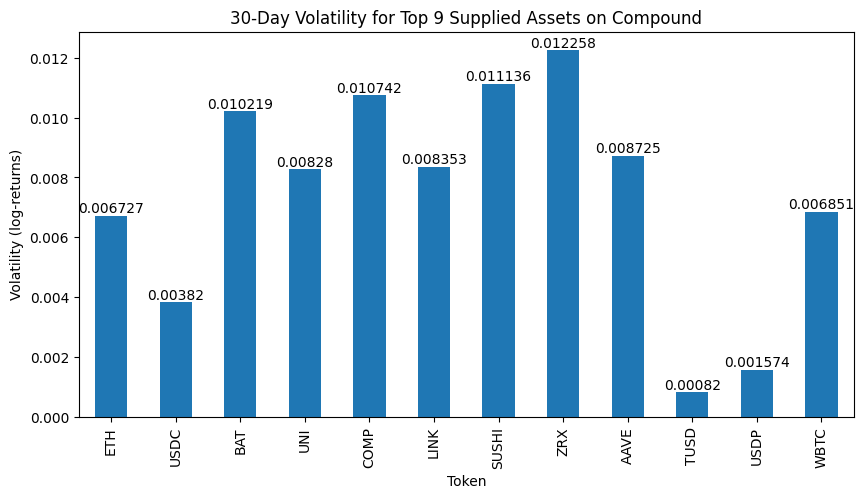

In [13]:
volatility_30d = {token: vsim.historical_volatility[token] for token in vsim.historical_volatility}
df_volatility = pd.DataFrame.from_dict(volatility_30d, orient='index', columns=['30-Day Volatility'])
ax = df_volatility.plot(kind='bar', figsize=(10, 5), legend=False)
plt.title('30-Day Volatility for Top 9 Supplied Assets on Compound')
plt.xlabel('Token')
plt.ylabel('Volatility (log-returns)')
for i, (index, row) in enumerate(df_volatility.iterrows()):
    ax.annotate(str(round(row['30-Day Volatility'], 6)), xy=(i, row['30-Day Volatility']), ha='center', va='bottom')
plt.show()

### calculte VaR

In [14]:
vsim.calculate_var(df_top_borrow_positions, n_simulations=1000)

100%|███████████████████████████████████████| 1000/1000 [15:43<00:00,  1.06it/s]


## results

### plot trajectories

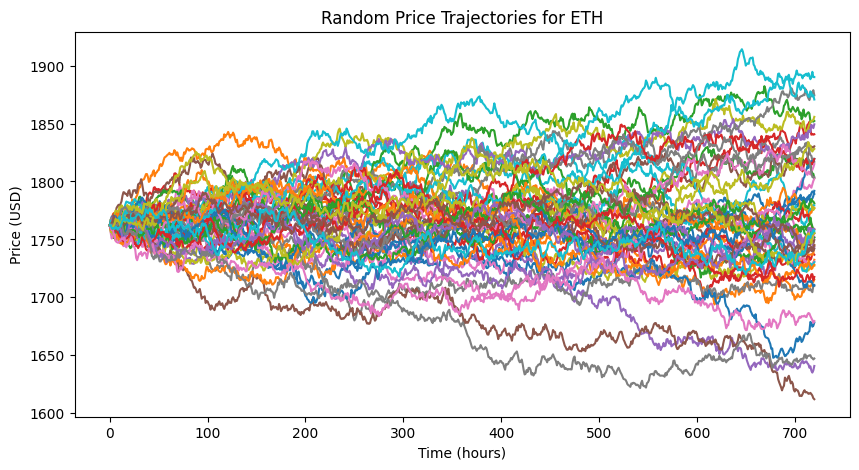

In [15]:
vsim.plot_price_trajectories('ETH', 50)

### plot VaR

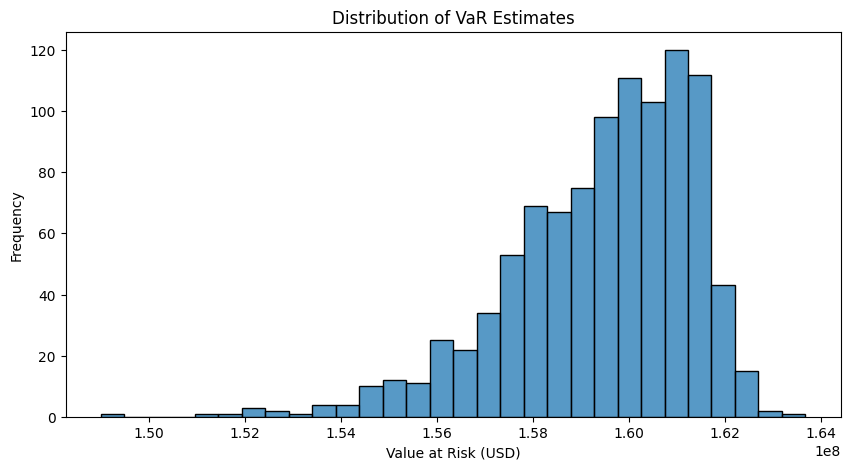

In [20]:
vsim.plot_var()